In [1]:
import os
import shutil
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
import cv2
import warnings

warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('train.csv')

train_df

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [3]:
train_df['image_name'] = train_df['image_id'] + '.jpg'

train_df 

,image_id,healthy,multiple_diseases,rust,scab,image_name
0,Train_0,0,0,0,1,Train_0.jpg
1,Train_1,0,1,0,0,Train_1.jpg
2,Train_2,1,0,0,0,Train_2.jpg
3,Train_3,0,0,1,0,Train_3.jpg
4,Train_4,1,0,0,0,Train_4.jpg
...,...,...,...,...,...,...
1816,Train_1816,0,0,0,1,Train_1816.jpg
1817,Train_1817,1,0,0,0,Train_1817.jpg
1818,Train_1818,1,0,0,0,Train_1818.jpg
1819,Train_1819,0,0,1,0,Train_1819.jpg


In [4]:
target_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']
labels = train_df[target_cols]
label_names = labels[labels==1].stack().reset_index()['level_1']
label_names.index = train_df.index
train_df['label_name'] = label_names
train_df

,image_id,healthy,multiple_diseases,rust,scab,image_name,label_name
0,Train_0,0,0,0,1,Train_0.jpg,scab
1,Train_1,0,1,0,0,Train_1.jpg,multiple_diseases
2,Train_2,1,0,0,0,Train_2.jpg,healthy
3,Train_3,0,0,1,0,Train_3.jpg,rust
4,Train_4,1,0,0,0,Train_4.jpg,healthy
...,...,...,...,...,...,...,...
1816,Train_1816,0,0,0,1,Train_1816.jpg,scab
1817,Train_1817,1,0,0,0,Train_1817.jpg,healthy
1818,Train_1818,1,0,0,0,Train_1818.jpg,healthy
1819,Train_1819,0,0,1,0,Train_1819.jpg,rust


In [5]:
def blur_preprocess(img):
    return cv2.blur(img, (5,5))

tf.random.set_seed(99)

#Initialize the data generators with augmentation
image_gen = ImageDataGenerator(rescale=1./255,
                                rotation_range=180,
                                validation_split=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                preprocessing_function=blur_preprocess)


train_generator = image_gen.flow_from_dataframe(dataframe=train_df,
                                                directory='images',
                                                x_col='image_name',
                                                y_col='label_name',
                                                target_size=(256,256),
                                                class_mode='categorical',
                                                batch_size=16,
                                                subset='training',
                                                shuffle=True,
                                                seed=42)

validation_generator = image_gen.flow_from_dataframe(dataframe=train_df,
                                                directory='images',
                                                x_col='image_name',
                                                y_col='label_name',
                                                target_size=(256,256),
                                                class_mode='categorical',
                                                batch_size=16,
                                                subset='validation',
                                                shuffle=True,
                                                seed=42)

Found 1457 validated image filenames belonging to 4 classes.
Found 364 validated image filenames belonging to 4 classes.


In [6]:
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.003,
                                                                        decay_steps=train_generator.n//train_generator.batch_size,
                                                                        decay_rate=0.97,
                                                                        staircase=False)


In [7]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_weights.h5',
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=False,
                                                save_weights_only=True,
                                                period=1)

In [9]:
def dense_net_model(trainable_weights=False, weight_path=None):
    tf.keras.backend.clear_session()
    dense_net = DenseNet201(include_top=False,
                            weights='imagenet',
                            input_shape=(256,256,3))

    for layer in dense_net.layers:
        layer.trainable = trainable_weights

    model = tf.keras.models.Sequential([dense_net,
                                        tf.keras.layers.GlobalAveragePooling2D(),
                                        tf.keras.layers.Dense(128, activation='relu'),
                                        tf.keras.layers.Dropout(0.3),
                                        tf.keras.layers.Dense(4, activation='softmax')])


    if weight_path:
        model.load_weights(weight_path)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

dense_net_transfer_model = dense_net_model(trainable_weights=True)

dense_net_transfer_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 8, 8, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               245888    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 18,568,388
Trainable params: 18,339,332
Non-trainable params: 229,056
_________________________________________________________________


In [10]:
dense_net_transfer_history = dense_net_transfer_model.fit(train_generator,
                                                        validation_data=validation_generator,
                                                        epochs=15,
                                                        callbacks=[checkpoint],
                                                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                                                        )


Train for 91 steps, validate for 23 steps
Epoch 1/15
90/91 [============================>.] - ETA: 1s - loss: 1.0369 - accuracy: 0.5432
Epoch 00001: saving model to model_weights.h5
91/91 [==============================] - 118s 1s/step - loss: 1.0358 - accuracy: 0.5441 - val_loss: 1495.5885 - val_accuracy: 0.3187
Epoch 2/15
90/91 [============================>.] - ETA: 0s - loss: 0.8244 - accuracy: 0.6035
Epoch 00002: saving model to model_weights.h5
91/91 [==============================] - 95s 1s/step - loss: 0.8243 - accuracy: 0.6037 - val_loss: 160.5616 - val_accuracy: 0.3187
Epoch 3/15
90/91 [============================>.] - ETA: 0s - loss: 0.7673 - accuracy: 0.6477
Epoch 00003: saving model to model_weights.h5
91/91 [==============================] - 96s 1s/step - loss: 0.7655 - accuracy: 0.6482 - val_loss: 6.0000 - val_accuracy: 0.4670
Epoch 4/15
90/91 [============================>.] - ETA: 0s - loss: 0.7515 - accuracy: 0.7011
Epoch 00004: saving model to model_weights.h5
91/91

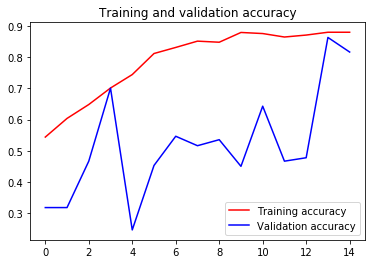

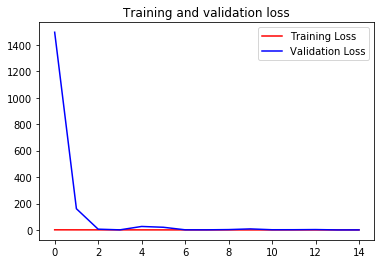

In [11]:
#plot loss and accuracy helper function
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure()
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_history(dense_net_transfer_history)

In [12]:
test_df = pd.read_csv('test.csv')
test_df['image_name'] = test_df['image_id'] + '.jpg'

test_generator = image_gen.flow_from_dataframe(dataframe=test_df,
                                                directory='images',
                                                x_col='image_name',
                                                y_col=None,
                                                target_size=(256,256),
                                                class_mode=None,
                                                batch_size=3,
                                                shuffle=False,
                                                seed=42)

Found 1821 validated image filenames.
